<center><h1>Titanic: Machine Learning from Disaster <i>(Solution Guide)</i></h1></center>

In [1]:
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
mpl.style.use('ggplot')
sns.set(rc={'figure.figsize': (9, 7)})
sns.set_style('white')
warnings.filterwarnings('ignore')
# print(os.listdir('../input'));

## 0. Data Retrieval

### Load Datasets

In [2]:
# Load training and testing datasets using pandas.read_csv() 
# train, test = pd.read_csv('../input/train.csv'), pd.read_csv('../input/test.csv')
train, test = pd.read_csv('./data/train.csv'), pd.read_csv('./data/test.csv')

# Print the shapes of both training and testing datasets
print('Training Dataset: %s, Testing Dastaset: %s' %(str(train.shape), str(test.shape)))

# Inspect column dtypes
train.dtypes.reset_index()

Training Dataset: (891, 12), Testing Dastaset: (418, 11)


,index,0
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
3,Name,object
4,Sex,object
5,Age,float64
6,SibSp,int64
7,Parch,int64
8,Ticket,object
9,Fare,float64


## 1. Data Preparation

### Data Processing & Wrangling, Exploratory Data Analysis

In [3]:
# Define function to detect outliers using z scores
def outliers_z_score(series, threshold=3):
    outliers = list()
    mean_, std_, threshold = np.mean(series), np.std(series), threshold
    z_scores = [(elem - mean_) / std_ for elem in series]
    return series[np.abs(z_scores) > threshold] 

#### Outliers
* Using the z-score and storing the indices of rows that we should drop (`outlier_ind`), we can better improve our accuracy as outliers can affect our predictions.

In [4]:
# Detect potential outliers for each feature in our training dataset using z scores
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
outlier_ind = list()
for num_feature in numeric_features:
    outliers = outliers_z_score(train[num_feature])
    index_outliers = list(outliers.index)
    outlier_ind += index_outliers

In [5]:
train = train.drop(list(set(outlier_ind)), axis=0)  # Drop outliers via indices
test_PassengerId = test['PassengerId']  # Store PassengerIds for testing dataset
dataset = train.append(test)  # Concatenate training, testing datasets
dataset = dataset.sort_values(by=['PassengerId']).reset_index(drop=True)
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [6]:
dataset = dataset.fillna(np.nan)  # Fill in empty values with NaN
dataset.isnull().sum()  # See which columns have NaN values

Age            254
Cabin          966
Embarked         2
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,825.000000,825.000000,825.000000,657.000000,825.000000,825.000000,825.000000
mean,445.596364,0.387879,2.306667,30.126591,0.347879,0.254545,25.889661
std,255.327509,0.487562,0.828361,14.030821,0.618445,0.564467,29.792940
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,447.000000,0.000000,3.000000,28.500000,0.000000,0.000000,13.000000
75%,662.000000,1.000000,3.000000,38.000000,1.000000,0.000000,27.720800
max,891.000000,1.000000,3.000000,71.000000,3.000000,2.000000,164.866700


#### Correlated Features 
* We can spot useful features that correlate with survival.

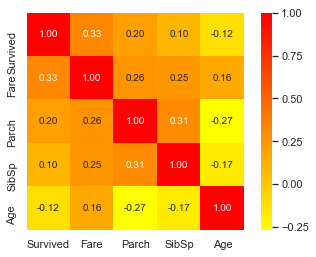

In [8]:
sns.heatmap(train[['Survived', 'Fare', 'Parch', 'SibSp', 'Age']].corr(), 
            annot=True, fmt='.2f', cmap='autumn_r', square=True);

#### Siblings
* Does the number of siblings "influence" the probability that the passenger will survive?

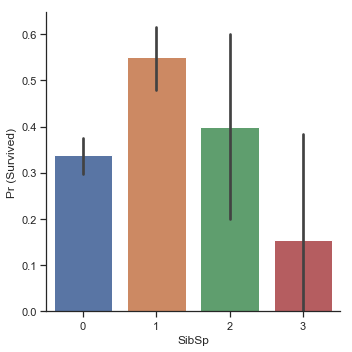

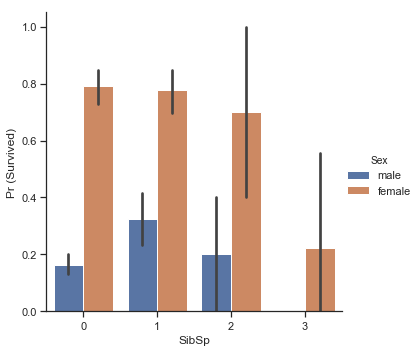

In [9]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('SibSp', 'Survived', data=train, kind='bar')
    g.set_axis_labels('SibSp', 'Pr (Survived)')
    g = sns.catplot('SibSp', 'Survived', 'Sex', data=train, kind='bar')
    g.set_axis_labels('SibSp', 'Pr (Survived)');

* Perhaps! The gap in survival between male and females are more interesting, confirming "***women and children first***." Let's continue to plot female vs. male for other features to confirm our suspicions.

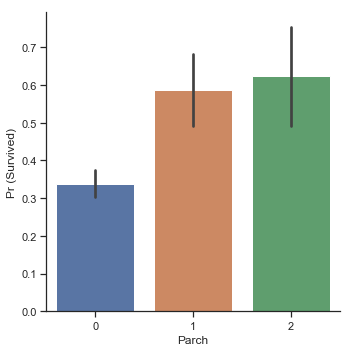

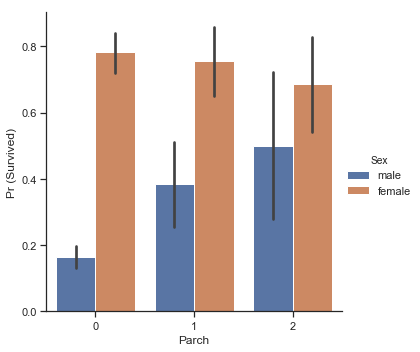

In [10]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('Parch', 'Survived', data=train, kind='bar')
    g.set_axis_labels('Parch', 'Pr (Survived)')
    g = sns.catplot('Parch', 'Survived', 'Sex', data=train, kind='bar')
    g.set_axis_labels('Parch', 'Pr (Survived)');

#### Passenger Class
* Does the passenger class feature (`Pclass`) show any interesting choices in survivors?

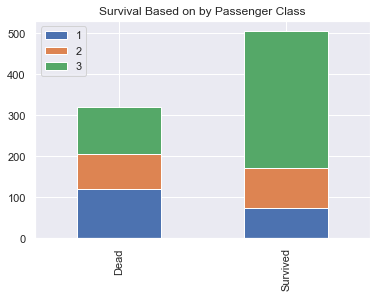

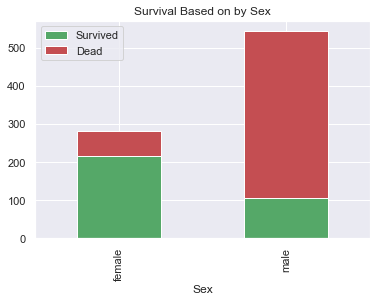

In [11]:
# Compare number of dead versus survived
survivors = train[train['Survived'] == 1]['Pclass'].value_counts()
dead = train[train['Survived'] == 0]['Pclass'].value_counts()
df_survival_pclass = pd.DataFrame([survivors, dead])
df_survival_pclass.index = ['Dead', 'Survived']
df_survival_pclass.plot(kind='bar', stacked=True, title='Survival Based on by Passenger Class')
train['Dead'] = 1 - train['Survived']
train.groupby('Sex').agg('sum')[['Survived', 'Dead']].plot(kind='bar', stacked=True, color=['g', 'r'], title='Survival Based on by Sex');

* It turns out, 1st class passengers seem to have an affinity for survival. Of course, the female vs. male graph is exactly what we expected: high female survival.

#### Age Distributions

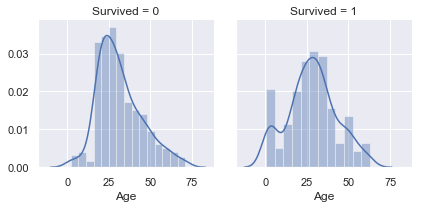

In [12]:
g = sns.FacetGrid(train, col='Survived')
g.map(sns.distplot, 'Age');

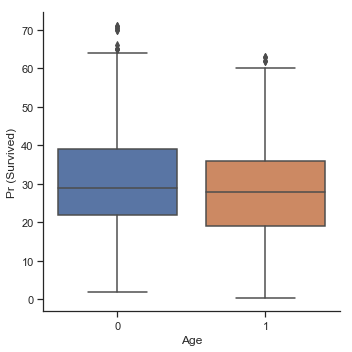

In [13]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
    g.set_axis_labels('Age', 'Pr (Survived)');

### Feature Engineering & Scaling, Feature Selection

In [14]:
print('Training Dataset:', train.shape)
print('Testing Dataset:', test.shape)
print('Complete Dataset:', dataset.shape)

Training Dataset: (825, 13)
Testing Dataset: (418, 11)
Complete Dataset: (1243, 12)


In [15]:
# Fill in NaN values using the median
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Fill in NaN values for 'Age' with similar group's median age or overall median
nan_age_index = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in nan_age_index:
    age_similar = dataset['Age'][(dataset['SibSp'] == dataset.loc[i]['SibSp']) & 
                   (dataset['Parch'] == dataset.loc[i]['Parch']) & 
                   (dataset['Pclass'] == dataset.loc[i]['Pclass'])].median()
    age_median = dataset['Age'].median()
    
    if not np.isnan(age_similar):
         dataset['Age'].loc[i] = age_similar
    else:
        dataset['Age'].loc[i] = age_median
        
train['Fare'], test['Fare'] = dataset['Fare'][:825], dataset['Fare'][825:]
train['Embarked'], test['Embarked'] = dataset['Embarked'][:825], dataset['Embarked'][825:]
train['Age'], test['Age'] = dataset['Age'][:825], dataset['Age'][825:]

#### Family Size
* We can use family size to try to better predict survival.

In [16]:
# Determine the family size based on 'Parch' and 'SibSp'
dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp']

# Assign calculated family sizes to individual training, testing datasets
train['FamilySize'] = dataset['FamilySize'][:825]
test['FamilySize'] = dataset['FamilySize'][825:]

#### Family Survival
*  From [S.Xu's kernel](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever), we can group families and people with the same tickets togerher and researches the info.

In [17]:
dataset['LastName'] = dataset['Name'].apply(lambda x: str.split(x, ",")[0])  # Get last name from 'Name'
DEFAULT_SURVIVAL_VALUE = 0.5
data_df['FamilySurvival'] = DEFAULT_SURVIVAL_VALUE

In [ ]:
encoder_embarked, encoder_sex = LabelEncoder(), LabelEncoder()

encoder_embarked.fit(dataset['Embarked'])
encoder_sex.fit(dataset['Sex'])

dataset['Embarked'] = encoder_embarked.transform(dataset['Embarked'])
dataset['Sex'] = encoder_sex.transform(dataset['Sex'])

In [ ]:
# Combine 'SibSp' and 'Parch' => 'Relatives'
dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']

In [ ]:
g = sns.catplot(x='Relatives', y='Survived', data=dataset, kind='point')
g.set_axis_labels('Relatives', 'Pr (Survived)');

In [ ]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [ ]:
scaler_age, scaler_age = StandardScaler(), StandardScaler()
dataset['Age'] = scaler_age.fit_transform(np.array(dataset['Age']).reshape(-1, 1))
dataset['Fare'] = scaler_age.fit_transform(np.array(dataset['Fare']).reshape(-1, 1))

In [ ]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Sex', 
            'SibSp', 'Relatives', 'Pc_1', 'Pc_2', 'Pc_3']

## 2. Modeling

### Model Selection

In [ ]:
train = dataset[dataset['PassengerId'].isin(train_PassengerId)]
test = dataset[dataset['PassengerId'].isin(test_PassengerId)]

In [ ]:
train['Survived'] = train['Survived'].astype(int)
test.drop(labels=['Survived'], axis=1,inplace=True)
train, test, train_survived = train[features], test[features], train['Survived']
X_train, y_train = train.values, train_survived.values
X_test = test.values

In [ ]:
kfold = StratifiedKFold(n_splits=10)
estimators = [AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1),
              DecisionTreeClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(),
              KNeighborsClassifier(), LinearDiscriminantAnalysis(), LogisticRegression(),
              MLPClassifier(), RandomForestClassifier(), SVC(), XGBClassifier()]

classifiers = list()
for est in estimators:
    classifiers.append(est)

In [ ]:
%%capture
cross_val_results = []
for classifier in classifiers :
    cross_val_results.append(cross_val_score(classifier, X_train, y_train, 
                                             scoring='accuracy', cv=kfold))
    
cross_val_means, cross_val_stds = [], []
for cv_result in cross_val_results:
    cross_val_means.append(cv_result.mean())
    cross_val_stds.append(cv_result.std())
    
df_cv = pd.DataFrame({'CrossValMeans':cross_val_means,
                      'CrossValErrors': cross_val_stds,
                      'Algorithms':['AdaBoost', 'DecisionTree', 'ExtraTrees', 'GradientBoosting',
                                    'KNeighboors', 'LinearDiscriminantAnalysis', 'LogisticRegression',
                                    'MultipleLayerPerceptron', 'RandomForest', 'SVC', 'XGBClassifier']})

In [ ]:
g = sns.barplot('CrossValMeans', 'Algorithms', data=df_cv, 
                palette='Set3', orient='h', **{'xerr':cross_val_stds})
g.set_xlabel('Mean Accuracy')
g.set_title('Cross Validation Scores');

In [ ]:
possible_models = df_cv.sort_values(by=['CrossValMeans'], ascending=False).reset_index(drop=True)
print(possible_models)

### Model Evaluation and Tuning

In [ ]:
estimator_scores = dict()

In [ ]:
# AdaBoost Classifier
dec_tree_est = DecisionTreeClassifier()
clf_AdaBoost_DTC = AdaBoostClassifier(dec_tree_est)

parameters_ada_tree = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__splitter': ['best', 'random'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'n_estimators': [1, 2]
}

clf_ada_tree = GridSearchCV(clf_AdaBoost_DTC, parameters_ada_tree, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_ada_tree.fit(X_train, y_train)

clf_ada_tree_best = clf_ada_tree.best_estimator_
estimator_scores[clf_ada_tree.best_score_] = clf_ada_tree_best
print('Best score: ', clf_ada_tree.best_score_)
print('Best params: ', clf_ada_tree.best_params_);

In [ ]:
# Extra Trees Classifier
clf_ExtraTrees = ExtraTreesClassifier()

parameters_extra_trees = {
    'bootstrap': [False],
    'criterion': ['gini'],
    'max_features': [1, 3, 10],
    'min_samples_leaf': np.linspace(0.1, 0.5, 4),
    'n_estimators': [300],
    'max_depth': [None]
}

clf_extra_trees = GridSearchCV(clf_ExtraTrees, parameters_extra_trees, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_extra_trees.fit(X_train, y_train)

clf_extra_trees_best = clf_extra_trees.best_estimator_
estimator_scores[clf_extra_trees.best_score_] = clf_extra_trees_best
print('Best score: ', clf_extra_trees.best_score_)
print('Best params: ', clf_extra_trees.best_params_);

In [ ]:
# Gradient Boosting Classifier
clf_GradientBoost = GradientBoostingClassifier()

parameters_gradient_boost = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'loss': ['deviance'],
    'max_depth': [3, 5, 8],
    'max_features': ['log2', 'sqrt'],
    'n_estimators': [300]
}

clf_gradient_boost = GridSearchCV(clf_GradientBoost, parameters_gradient_boost, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_gradient_boost.fit(X_train, y_train)

clf_gradient_boost_best = clf_gradient_boost.best_estimator_
estimator_scores[clf_gradient_boost.best_score_] = clf_gradient_boost_best
print('Best score: ', clf_gradient_boost.best_score_)
print('Best params: ', clf_gradient_boost.best_params_);

In [ ]:
# Multiple Layer Perceptron Classifier
clf_MLP = MLPClassifier()

parameters_MLP = {
    'alpha': [1e-2, 1e-3, 1e-4],
    'max_iter': np.arange(1000, 2001, 500),
    'hidden_layer_sizes': [10],
    'solver': ['lbfgs']
}

clf_mlp = GridSearchCV(clf_MLP, parameters_MLP, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_mlp.fit(X_train, y_train)

clf_mlp_best = clf_mlp.best_estimator_
estimator_scores[clf_mlp.best_score_] = clf_mlp_best
print('Best score: ', clf_mlp.best_score_)
print('Best params: ', clf_mlp.best_params_);

In [ ]:
%%capture
# XG Boost Classifier
clf_XGBoost = XGBClassifier()

parameters_xg_boost = {
    'gamma': [0.5, 1, 1.5, 2, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [300],
    'subsample': [0.6, 0.8, 1.0],
}

clf_xg_boost = GridSearchCV(clf_XGBoost, parameters_xg_boost, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_xg_boost.fit(X_train, y_train)

clf_xg_boost_best = clf_xg_boost.best_estimator_
estimator_scores[clf_xg_boost.best_score_] = clf_xg_boost_best

In [ ]:
print('Best score: ', clf_xg_boost.best_score_);
print('Best params: ', clf_xg_boost.best_params_);

In [ ]:
best_score = max(estimator_scores.keys())
best_classifier = estimator_scores[best_score]

print(best_classifier);

## 3. Deployment & Prediction

In [ ]:
y_pred = best_classifier.predict(X_test)
test['PassengerId'], test['Survived'] = test_PassengerId.values, y_pred
result = test[['PassengerId', 'Survived']]
result.to_csv('titanic_predictions.csv', index=False);